In [ ]:
!pip install torchgan

In [ ]:
# Code based on https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/dcgan/dcgan.py, which is released under the MIT license
# Also used https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

# imports
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as col
import torchgan.layers as L

# hyperparameters
batch_size  = 64
n_channels  = 1
dataset_name = 'stl10'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
# optional Google drive integration - this will allow you to save and resume training, and may speed up redownloading the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x


# you may use cifar10 or stl10 datasets
if dataset_name == 'stl10':
    # Code from https://discuss.pytorch.org/t/how-to-use-one-class-of-number-in-mnist/26276
    dataset = torchvision.datasets.CIFAR10('drive/My Drive/training/cifar10', train=True, download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.RandomHorizontalFlip(), torchvision.transforms.ToTensor(), torchvision.transforms.Grayscale()
        ]))
    filtered_dataset = [e for e in filter(lambda k: k[1] == 7, dataset)]
    # print(filtered_dataset)
    cifar_loader = torch.utils.data.DataLoader(
        filtered_dataset, shuffle=True, batch_size=batch_size, drop_last=True
    )
    class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

if dataset_name == 'mnist':
    dataset = torchvision.datasets.MNIST('drive/My Drive/training/mnist32', train=True, download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(32), torchvision.transforms.ToTensor(),
        ]))
    
    # filtered_dataset = [e for e in filter(lambda k: k[1] == 2, dataset)]
    train_loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=batch_size, drop_last=True)
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# stl10 has larger images which are much slower to train on. You should develop your method with CIFAR-10 before experimenting with STL-10
if dataset_name == 'stl10':
    dataset = torchvision.datasets.STL10('drive/My Drive/training/stl10', split='test', download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.RandomHorizontalFlip(), torchvision.transforms.ToTensor(), torchvision.transforms.Grayscale()
        ]))
    filtered_dataset = [e for e in filter(lambda k: k[1] == 6, dataset)]
    stl_loader = torch.utils.data.DataLoader(
        filtered_dataset, shuffle=True, batch_size=batch_size, drop_last=True
        )
    class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'] # these are slightly different to CIFAR-10

cifar_iterator = iter(cycle(cifar_loader))
stl_iterator = iter(cycle(stl_loader))

Files already downloaded and verified
Files already downloaded and verified


800


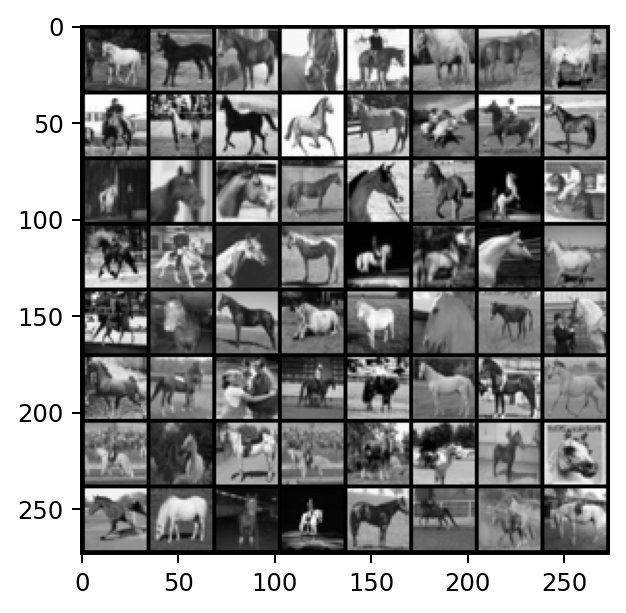

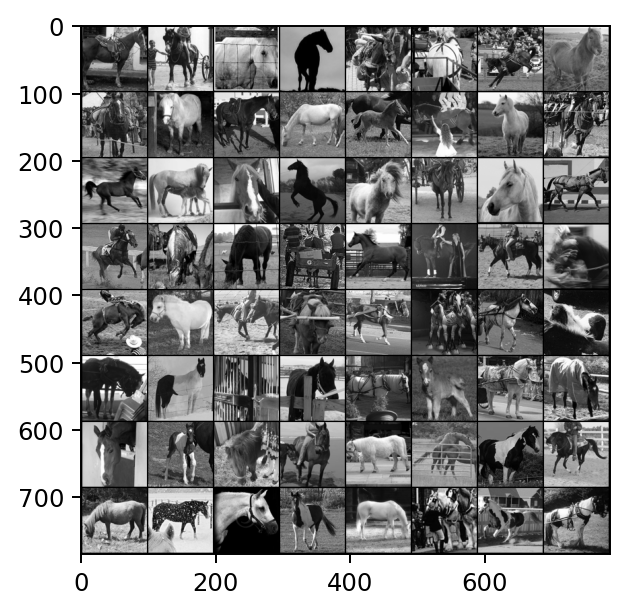

In [ ]:
# let's view some of the training data
print(len(filtered_dataset))
plt.rcParams['figure.dpi'] = 175
x,t = next(cifar_iterator)
x,t = x.to(device), t.to(device)
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(x).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

x,t = next(stl_iterator)
x,t = x.to(device), t.to(device)
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(x).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

In [ ]:
# This code is from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

**Define a GAN**

In [ ]:
# hyperparameters
n_noise = 100
n_labels = len(class_names)
latent_size = 32

# simple block of convolution, batchnorm, and leakyrelu
class Block(nn.Module):
    def __init__(self, in_f, out_f):
        super(Block, self).__init__()
        self.f = nn.Sequential(
            nn.Conv2d(in_f, out_f, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_f),
            nn.LeakyReLU(inplace=True)
        )
    def forward(self,x):
        return self.f(x)

class FirstStep(nn.Module):
    def __init__(self, in_f, out_f, size=2):
        super(FirstStep, self).__init__()
        self.in_f = in_f
        self.out_f = out_f
        self.size = size
        self.layer = nn.Sequential(
            nn.Linear(in_f, out_f*size*size),
            nn.BatchNorm1d(out_f*size*size)
        )

    def forward(self, x):
        x = self.layer(x)
        x = x.view(x.size(0), self.out_f, self.size, self.size)
        return x

class Generator(nn.Module):
    def __init__(self, f=64):
        super(Generator, self).__init__()
        self.f = f
        
        def block(in_f, out_f, scale=2):
            return [
                    nn.Upsample(scale_factor=scale),
                    nn.Conv2d(in_f, out_f, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(out_f),
                    nn.LeakyReLU(),
                    nn.Conv2d(out_f, out_f, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(out_f),
                    nn.LeakyReLU()
            ]

        # Architecture as per the following paper
        # https://arxiv.org/pdf/1710.10196.pdf?__hstc=200028081.1bb630f9cde2cb5f07430159d50a3c91.1524009600081.1524009600082.1524009600083.1&__hssc=200028081.1.1524009600084&__hsfp=1773666937
        self.prog_conv = nn.ModuleDict({
            'label_embedding': nn.Sequential(
                nn.Linear(n_labels, latent_size),
                nn.LeakyReLU(inplace=True)
            ),
            'init4x4': nn.Sequential(
                # Takes input of shape 64*channels*1*1
                nn.Conv2d(n_noise, f, kernel_size=4, stride=1, padding=3), # 4x4
                nn.BatchNorm2d(f),
                nn.LeakyReLU(),
                nn.Conv2d(f, f, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(f),
                nn.LeakyReLU()
            ),
            '8x8': nn.Sequential(
                *block(f, f)
            ),
            '16x16': nn.Sequential(
                *block(f, f)
            ),
            '32x32': nn.Sequential(
                *block(f, f)
            ),
            '96x96': nn.Sequential(
                *block(f, f, scale=3)
            ),
            'toRGB': nn.Sequential(
                nn.Conv2d(f, n_channels, kernel_size=1, stride=1, padding=0),
                nn.Tanh()
            )
        })

    def forward(self, x, y, scale, training=1):
        scales = ['init4x4', '8x8', '16x16', '32x32', '96x96'] # scale = 1, 2, 3, 4
        # y = self.prog_conv['label_embedding'](y)
        # x = torch.cat((x, y), dim=1).view(batch_size, n_noise + latent_size, 1, 1).to(device)
        x = x.view(batch_size, n_noise, 1, 1)
        for layer_key in scales[:scale]:
            x = self.prog_conv[layer_key](x)
        if training < 1:
            x_hat = self.prog_conv[scales[scale]](x)
            if scale < 4:
                x = nn.Upsample(scale_factor=2)(x)
            else:
                x = nn.Upsample(scale_factor=3)(x)
            # print('gen', x.shape)
            x = training * x_hat + (1 - training) * x
        x = self.prog_conv['toRGB'](x)
        return x

spectral_norm = nn.utils.spectral_norm

class Discriminator(nn.Module):
    def __init__(self, f=64):
        super(Discriminator, self).__init__()

        # Code inspired by https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/dcgan/dcgan.py
        def block(in_f, out_f, scale=2):
            return [
                    spectral_norm(nn.Conv2d(in_f, in_f, kernel_size=3, stride=1, padding=1)),
                    nn.LeakyReLU(),
                    spectral_norm(nn.Conv2d(in_f, out_f, kernel_size=3, stride=1, padding=1)),
                    nn.LeakyReLU(),
                    nn.AvgPool2d(kernel_size=scale)
            ]

        self.prog_disc = nn.ModuleDict({
            'fromRGB': nn.Sequential(
                spectral_norm(nn.Conv2d(n_channels, f, kernel_size=1, stride=1, padding=0)),
                nn.LeakyReLU()
            ),
            '32x32': nn.Sequential(
                *block(f, f, scale=3)
            ),
            '16x16': nn.Sequential(
                *block(f, f)
            ),
            '8x8': nn.Sequential(
                *block(f, f)
            ),
            '4x4': nn.Sequential(
                *block(f, f)
            ),
            '1x1': nn.Sequential(
                spectral_norm(nn.Conv2d(f, f*2, kernel_size=4)),
                nn.Flatten(),
                nn.Linear(f*2, 128),
                L.MinibatchDiscrimination1d(128, 4)
            ),
            'final': nn.Sequential(
                nn.Linear(128 + 4, 64),
                nn.LeakyReLU(inplace=True),
                nn.Linear(64, 1),
                nn.Tanh()
            )
        })
          
    def forward(self, x, y, scale, training=1):
        scales = ['1x1', '4x4', '8x8', '16x16', '32x32']
        # print(x.shape)
        if training < 1:
            if scale < 4:
                x_hat = nn.AvgPool2d(kernel_size=2)(x)
            else:
                x_hat = nn.AvgPool2d(kernel_size=3)(x)
            x_hat = self.prog_disc['fromRGB'](x_hat)
            x = self.prog_disc['fromRGB'](x)
            x = self.prog_disc[scales[scale]](x)
            # print(x.shape, x_hat.shape)
            x = training * x + (1 - training) * x_hat
        else:
            x = self.prog_disc['fromRGB'](x)
        
        for layer_key in scales[scale-1:0:-1]:
            x = self.prog_disc[layer_key](x)
        x = self.prog_disc['1x1'](x)
        return self.prog_disc['final'](x), x

# class Qnet(nn.Module):
#     def __init__(self, f=128):
#         super(Qnet, self).__init__()

#         self.layers = nn.ModuleList([
#             nn.Linear(128, 64),
#             nn.BatchNorm1d(64),
#             nn.LeakyReLU(inplace=True),
#             nn.Linear(64, n_labels),
#             nn.BatchNorm1d(n_labels),
#             nn.ReLU(inplace=True)
#         ])

#     def forward(self, x):
#         for layer in self.layers:
#             # print(layer)
#             x = layer(x)
#             # print(x.shape)
#         return torch.softmax(x, dim=-1)

G = Generator().to(device)
# This line also from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
G.apply(weights_init)
# Q = Qnet().to(device)
print(f'> Number of gen parameters {len(torch.nn.utils.parameters_to_vector(G.parameters()))}')
D = Discriminator().to(device)
# One more from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
D.apply(weights_init)
print(f'> Number of dis parameters {len(torch.nn.utils.parameters_to_vector(D.parameters()))}')

optimiser_g = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimiser_d = torch.optim.SGD(D.parameters(), lr=0.001, momentum=0.00005)
bce_loss = nn.BCELoss()
ce_loss = nn.CrossEntropyLoss()
mse_loss = nn.MSELoss()
grad_clip = 0.01

> Number of gen parameters 436513
> Number of dis parameters 460033


**Main training loop**

In [ ]:
num_iters = 250
num_epochs = 30
for k in range(10, 11):
    scale = k // 2
    is_train = k % 2
    epoch = 0
    while (epoch<num_epochs):
        
        # array(s) for the performance measures
        train_loss_arr = np.zeros(0)
        loss_d_arr = np.zeros(0)
        fake_arr = np.zeros(0)
        real_arr = np.zeros(0)

        # iterate over some of the train dateset
        for i in range(num_iters):
            if is_train:
                training = (epoch * num_iters + i) / (num_epochs * num_iters)
            else:
                training = 1

            # sample x from the dataset
            if k < 9:
                x,t = next(cifar_iterator)
                x = F.interpolate(x, size=2**(scale+1)) if training == 1 else F.interpolate(x, size=2**(scale+2))
            else:
                x, t = next(stl_iterator)
                # x = F.interpolate(x, size=32) if training == 1 else F.interpolate(x, size=64)

            x,t = x.to(device), t.to(device)

            # Normalise x in range [-1, 1]
            x = (x - 0.5) * 2
            y = torch.zeros(x.size(0), 10).long().to(device).scatter(1, t.view(x.size(0),1), 1).float().to(device)

            # Train discriminator
            noise = torch.randn(x.size(0), n_noise).to(device)
            g = G(noise, y, scale, training).detach()
            # image_noise = torch.randn(batch_size, n_channels, 32, 32).to(device) / epoch
            r_o, r_feat = D(x, y, scale, training)
            f_o, f_feat = D(g, y, scale, training)
            # l_r = bce_loss(r_o.mean(), torch.full(tuple([1]), 0.9)[0].to(device))
            l_r = mse_loss(r_o, torch.ones((batch_size, 1)).to(device))
            l_f = mse_loss(f_o, -torch.ones((batch_size, 1)).to(device))
            # l_f = bce_loss(f_o.mean(), torch.zeros(1)[0].to(device))
            loss_d = (l_r + l_f) / 2
            optimiser_d.zero_grad()
            loss_d.backward()
            # Code from https://stackoverflow.com/questions/54716377/how-to-do-gradient-clipping-in-pytorch
            # nn.utils.clip_grad_value_(D.parameters(), grad_clip)
            optimiser_d.step()

            # Train generator
            noise = torch.randn(x.size(0), n_noise).to(device)
            g = G(noise, y, scale, training)
            f_o, f_feat = D(g, y, scale, training)
            _, r_feat = D(x, y, scale, training)
            # loss_g_feat = mse_loss(f_feat, r_feat)
            # loss_g = bce_loss(f_o.mean(), torch.ones(1)[0].to(device))
            # loss_g = loss_g + 0.3*loss_g_feat

            loss_g = mse_loss(f_o, torch.zeros((batch_size, 1)).to(device))
            # y_hat = Q(f_feat.detach())
            # loss_q = ce_loss(y_hat, t)

            # backpropagate to compute the gradient of the loss w.r.t the parameters and optimise
            optimiser_g.zero_grad()
            loss_g.backward()
            optimiser_g.step()

            

            # collect stats
            train_loss_arr = np.append(train_loss_arr, loss_g.cpu().data)
            loss_d_arr = np.append(loss_d_arr, loss_d.cpu().data)

        # sample your model (autoencoders are not good at this)

        epoch = epoch+1

        # plot some examples
        if epoch % 1 == 0:
            G.eval()
            D.eval()
            x, t = next(train_iterator)
            x, t = x.to(device), t.to(device)
            x = (x - 0.5) * 2
            print('Epoch', epoch, 'at scale', scale)
            g = G(torch.randn(x.size(0), n_noise).to(device), y, scale)
            # f_o, f_feat = D(g)
            # r_o, r_feat = D(x)
            # d_f = (f_o < 0.5).float().sum() / x.size(0)
            # d_r = (r_o > 0.5).float().sum() / x.size(0)
            print('G loss: {:.3f}; D loss : {:.3f}'.format(train_loss_arr.mean(), loss_d_arr.mean()))
            plt.rcParams['figure.dpi'] = 150
            # Renormalise g
            g = (g / 2) + 0.5
            x = (x / 2) + 0.5
            plt.grid(False)
            plt.imshow(torchvision.utils.make_grid(g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
            plt.show()
            plt.pause(0.0001)
            G.train()
            D.train()

    

['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


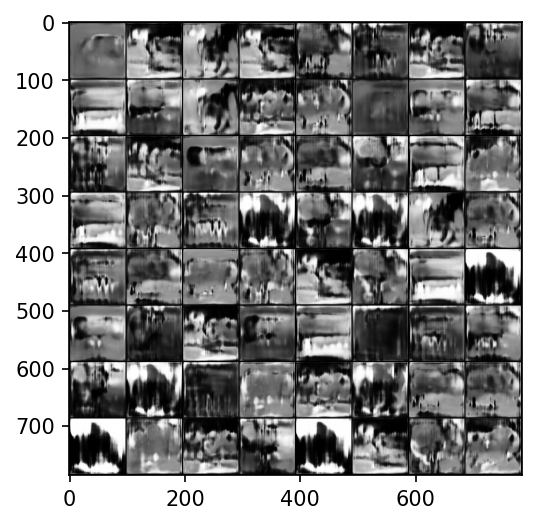

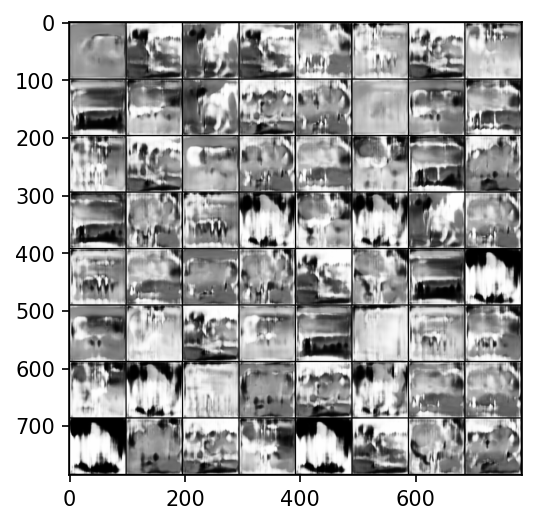

In [ ]:
noise = torch.randn(x.size(0), n_noise).to(device)
g = G(noise, y, scale)
g = (g / 2) + 0.5
print(class_names)
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()
g = 1 - g
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

**Recolour images**

In [ ]:
dataset = torchvision.datasets.STL10('drive/My Drive/training/stl10', split='test', download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.RandomHorizontalFlip(), torchvision.transforms.ToTensor()
        ]))
filtered_dataset = [e for e in filter(lambda k: k[1] == 6, dataset)]
stl_loader = torch.utils.data.DataLoader(
    filtered_dataset, shuffle=True, batch_size=batch_size, drop_last=True
    )
class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'] # these are slightly different to CIFAR-10


colour_iterator = iter(cycle(stl_loader))

Files already downloaded and verified


In [ ]:
class Crayon(nn.Module):
    def __init__(self, f=16):
        super(Crayon, self).__init__()
        self.f = f

        def block(in_f, out_f):
            return [
                    nn.Conv2d(in_f, out_f, kernel_size=3, stride=1, padding=1),
                    nn.LeakyReLU(),
                    nn.BatchNorm2d(out_f)
            ]
        
        self.layers = nn.Sequential(
            *block(1, f),
            *block(f, f*2),
            *block(f*2, f*4),
            *block(f*4, f*2),
            *block(f*2, f),
            *block(f, 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

C = Crayon().to(device)
optimiser_c = torch.optim.Adam(C.parameters(), lr=0.0002, betas=(0.5, 0.999))
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(C.parameters()))}')

> Number of parameters 47145


In [ ]:
for epoch in range(50):
    iterations = 0
    loss_arr = np.zeros(0)
    while iterations < 250:
        x, _ = next(colour_iterator)
        x = x.to(device)

        # Grayscale
        x_gray = (0.299*x[:, 0] + 0.587*x[:, 1] + 0.114*x[:, 2]).view(64, 1, 96, 96)

        # Train
        x_recon = C(x_gray)
        recon_loss = mse_loss(x_recon, x)

        optimiser_c.zero_grad()
        recon_loss.backward()
        optimiser_c.step()

        loss_arr = np.append(loss_arr, recon_loss.cpu().data)
        iterations += 1
    print(f'Epoch {epoch+1} average loss: {loss_arr.mean()}')



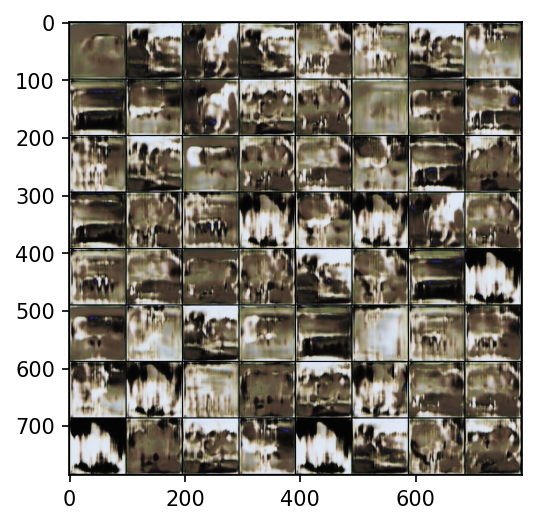

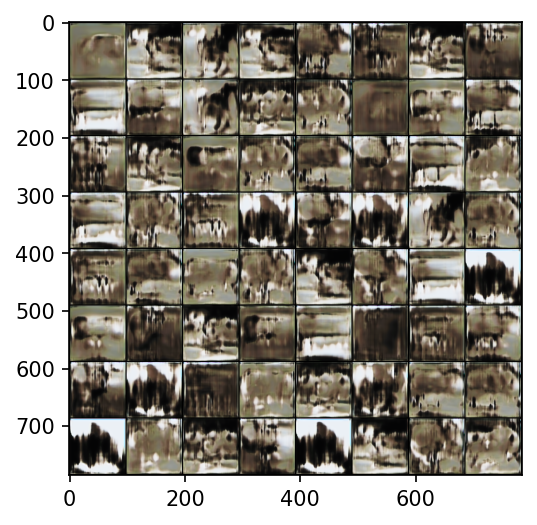

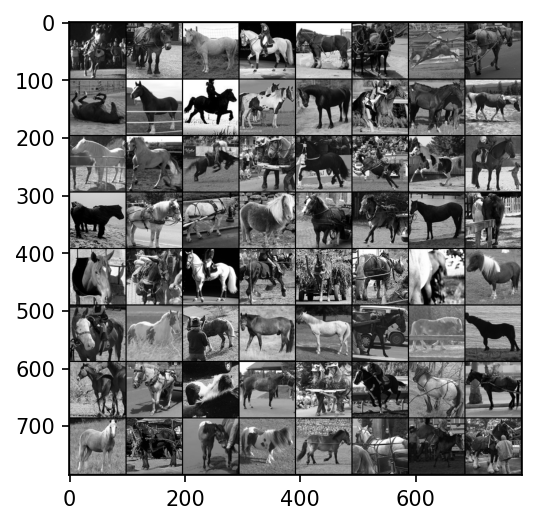

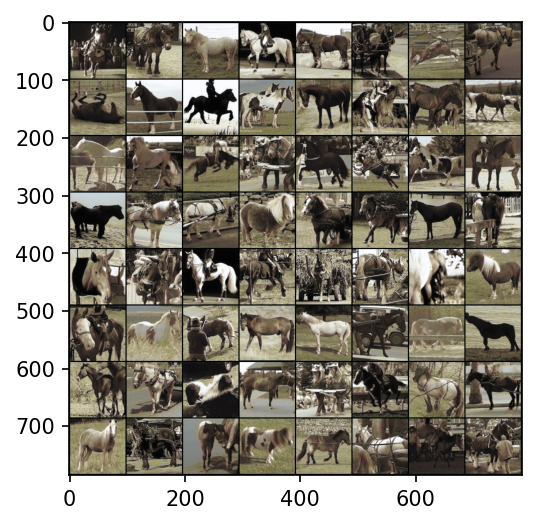

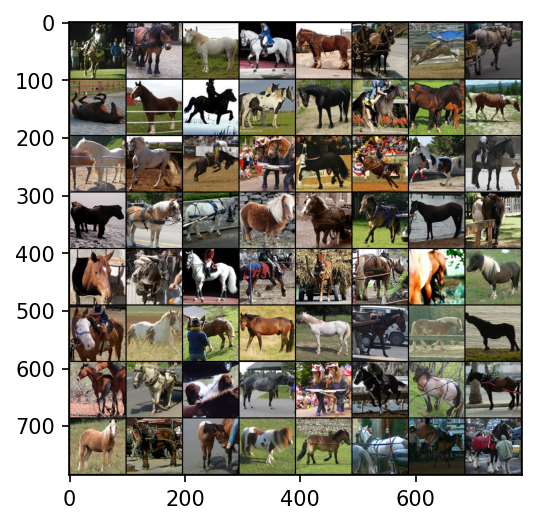

In [ ]:
# Output batch
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(C(1-g)).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

# Without colour inversion
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(C(g)).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()
plt.grid(False)

# Demonstrate gray -> colour -> ground truth
plt.imshow(torchvision.utils.make_grid(x_gray).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(C(x_gray)).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(x).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

In [ ]:
# optional example code to save your training progress for resuming later if you authenticated Google Drive previously
torch.save({'G':G.state_dict(), 'D': D.state_dict(), 'optimiser_g':optimiser_g.state_dict(), 'optimiser_d':optimiser_d.state_dict(), 'epoch':epoch}, 'drive/My Drive/training/save.chkpt')

In [ ]:
torch.save({'C':C.state_dict(), 'optimiser_c':optimiser_c.state_dict()}, 'drive/My Drive/training/save_colour.chkpt')

In [ ]:
# optional example to resume training if you authenticated Google Drive previously
params = torch.load('drive/My Drive/training/save.chkpt')
G.load_state_dict(params['G'])
D.load_state_dict(params['D'])
optimiser_g.load_state_dict(params['optimiser_g'])
optimiser_d.load_state_dict(params['optimiser_d'])
epoch = params['epoch']

In [ ]:
params = torch.load('drive/My Drive/training/save_colour.chkpt')
C.load_state_dict(params['C'])
optimiser_c.load_state_dict(params['optimiser_c'])